In [1]:
from __future__ import division

import os
import matplotlib.pyplot as plt
import numpy as np
import skbio
import scipy.stats
import statsmodels.api as sms
import statsmodels.formula.api as smf

import absloute_power.traditional as trad
import absloute_power.utils as ap


import pandas as pd
import biom

from skbio.stats.power import subsample_power

from absloute_power.traditional import calc_ttest_1

In [2]:
import pickle

In [3]:
base_dir = '/Users/jwdebelius/Repositories/Absloute-Power'
data_dir = os.path.join(base_dir, 'data/yatsunenko')
map_fp = os.path.join(data_dir, 'GG_100nt_even1k.txt')
otu_fp = os.path.join(data_dir, 'GG_100nt_even1k.biom')
uud_fp = os.path.join(data_dir, '1k/unweighted_unifrac_dm.txt')

In [4]:
map_ = pd.read_csv(map_fp, sep='\t', dtype=str)
map_.set_index('#SampleID', inplace=True)
uud = skbio.DistanceMatrix.read(uud_fp)

In [5]:
map_.columns

Index([u'BarcodeSequence', u'LinkerPrimerSequence', u'LAB_PERSON_CONTACT',
       u'TARGET_SUBFRAGMENT', u'ASSIGNED_FROM_GEO', u'LAB_PERSON',
       u'EXPERIMENT_CENTER', u'TITLE', u'RUN_PREFIX', u'AGE', u'AGE_CAT',
       u'INVESTIGATION_TYPE', u'HOST_COMMON_NAME', u'DEPTH', u'HOST_TAXID',
       u'SUBMIT_TO_INSDC', u'COMMON_NAME', u'INCLUDES_TIMESERIES',
       u'LONGITUDE', u'BODY_SITE', u'PROJECT_NAME', u'ELEVATION', u'RUN_DATE',
       u'SEQUENCING_METH', u'COLLECTION_DATE', u'ALTITUDE', u'RUN_LANE',
       u'ENV_BIOME', u'SEX', u'PLATFORM', u'FAMILY_RELATIONSHIP',
       u'STUDY_CENTER', u'COUNTRY', u'FLXDATA_PUBLISHED', u'STUDY_TITLE',
       u'STUDY_ALIAS', u'HOST_SUBJECT_ID', u'ANONYMIZED_NAME', u'TAXON_ID',
       u'SAMPLE_CENTER', u'NEWILLUMINADATAGENERATED',
       u'PRINCIPAL_INVESTIGATOR', u'STUDY_DESCRIPTION', u'PUBLICATION_ALIAS',
       u'AGE_UNIT', u'MIENS_COMPLIANT', u'STUDY_ID',
       u'EXPERIMENT_DESIGN_DESCRIPTION', u'Description_duplicate',
       u'BODY_HABITAT

In [20]:
def test_beta_permanova(ids, meta, dm, cat, num_iter=99):
    """Tests difference in beta diversity for a category and distance matrix"""
    # Gets the map and distance matrix subset
    all_ids = np.hstack(ids)
    # Calculates the permanova
    perma_results = skbio.stats.distance.permanova(dm.filter(all_ids), 
                                                   meta.loc[all_ids],
                                                   cat,
                                                   num_iter)
    # Returns the p value
    return perma_results['p-value']

In [21]:
map_.groupby('AGE_CAT').count().max(1)

AGE_CAT
adult    223
baby     137
child     59
teen     109
dtype: int64

In [22]:
map_.groupby(['AGE_CAT', 'COUNTRY']).count().max(1)

AGE_CAT  COUNTRY                     
adult    GAZ:Malawi                       52
         GAZ:United States of America    136
         GAZ:Venezuela                    35
baby     GAZ:Malawi                       60
         GAZ:United States of America     50
         GAZ:Venezuela                    27
child    GAZ:United States of America     25
         GAZ:Venezuela                    34
teen     GAZ:Malawi                        2
         GAZ:United States of America    104
         GAZ:Venezuela                     3
dtype: int64

In [23]:
map_.loc[map_.COUNTRY == 'GAZ:United States of America'].groupby('AGE_CAT').count().max(1)

AGE_CAT
adult    136
baby      50
child     25
teen     104
dtype: int64

In [24]:
us_peps = map_.loc[(map_.COUNTRY == 'GAZ:United States of America')]
us_peps = us_peps.loc[inter_ids]

In [25]:
inter_ids = list(set(map_.index).intersection(set(uud.ids)))

In [26]:
age_test = lambda x: test_beta_permanova(x, map_, uud, 'AGE_CAT')
nat_test = lambda x: test_beta_permanova(x, map_, uud, 'COUNTRY')

In [27]:
age_ids = [ids for ids in map_.loc[inter_ids].groupby('AGE_CAT').groups.itervalues()]
nat_ids = [ids for ids in map_.loc[inter_ids].groupby('COUNTRY').groups.itervalues()]

In [11]:
age_test(age_ids)

0.01

In [12]:
nat_test(nat_ids)

0.01

In [13]:
age_power, age_counts = subsample_power(age_test, age_ids, min_counts=3, max_counts=15, counts_interval=1)
nat_power, nat_counts = subsample_power(nat_test, nat_ids, min_counts=3, max_counts=15, counts_interval=1)

In [14]:
with open(os.path.join(data_dir, 'power.p'), 'wb') as f_:
    pickle.dump([age_power, age_counts, nat_power, nat_counts], f_)

### ids

In [16]:
sub_map_age = map_.loc[inter_ids].groupby('AGE_CAT').groups

In [18]:
sub_map_age.keys()

['baby', 'teen', 'adult', 'child']

In [19]:
b_a_ids = [sub_map_age[g] for g in ['adult', 'baby']]
c_a_ids = [sub_map_age[g] for g in ['adult', 'child']]
t_a_ids = [sub_map_age[g] for g in ['adult', 'teen']]
t_c_ids = [sub_map_age[g] for g in ['teen', 'child']]
t_b_ids = [sub_map_age[g] for g in ['teen', 'baby']]
c_b_ids = [sub_map_age[g] for g in ['child', 'baby']]

In [22]:
# child_ids = [sub_map_age[g] for g in ['Adult', 'Child']]
b_a_power, b_a_counts = subsample_power(age_test, b_a_ids, min_counts=3, max_counts=15, counts_interval=1)
b_t_power, b_t_counts = subsample_power(age_test, t_b_ids, min_counts=3, max_counts=15, counts_interval=1)
b_c_power, b_c_counts = subsample_power(age_test, c_b_ids, min_counts=3, max_counts=15, counts_interval=1)

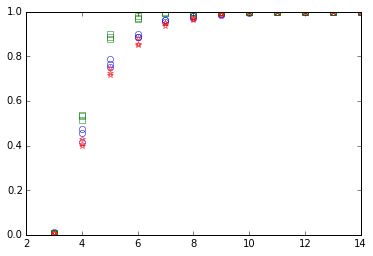

In [32]:
% matplotlib inline
plt.plot(b_a_counts, b_a_power[0, :], 'o', mfc='none', mec='b')
plt.plot(b_a_counts, b_a_power[1, :], 'o', mfc='none', mec='b')
plt.plot(b_a_counts, b_a_power[2, :], 'o', mfc='none', mec='b')
plt.plot(b_t_counts, b_t_power[0, :], 's', mfc='none', mec='g')
plt.plot(b_t_counts, b_t_power[1, :], 's', mfc='none', mec='g')
plt.plot(b_t_counts, b_t_power[2, :], 's', mfc='none', mec='g')
plt.plot(b_c_counts, b_c_power[0, :], '*', mfc='none', mec='r')
plt.plot(b_c_counts, b_c_power[1, :], '*', mfc='none', mec='r')
plt.plot(b_c_counts, b_c_power[2, :], '*', mfc='none', mec='r')

In [33]:
c_a_power, b_a_counts = subsample_power(age_test, t_a_ids, min_counts=5, max_counts=30, counts_interval=5)
c_t_power, b_t_counts = subsample_power(age_test, t_c_ids, min_counts=5, max_counts=30, counts_interval=5)
t_a_power, b_c_counts = subsample_power(age_test, c_a_ids, min_counts=5, max_counts=30, counts_interval=5)

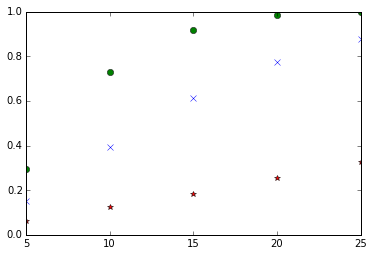

In [38]:
plt.plot(b_a_counts, c_a_power.mean(0), 'x')
plt.plot(b_t_counts, c_t_power.mean(0), 'o')
plt.plot(b_c_counts, t_a_power.mean(0), '*')

In [39]:
age_power = {('baby',  'adult'): [np.arange(3, 15, 1), b_a_power],
             ('baby',  'teen' ): [np.arange(3, 15, 1), b_t_power],
             ('baby',  'child'): [np.arange(3, 15, 1), b_c_power],
             ('child', 'adult'): [b_a_counts, c_a_power],
             ('child', 'teen' ): [b_t_counts, c_t_power],
             ('teen',  'adult'): [b_c_counts, t_a_power]
            }

In [40]:
with open(os.path.join(data_dir, 'age.p'), 'wb') as f_:
    pickle.dump(age_power, f_)

In [5]:
with open(os.path.join(data_dir, 'age.p'), 'rb') as f_:
    age_power = pickle.load(f_)

In [11]:
for k, (cnt, pwr) in age_power.iteritems():
    eff = ap.z_effect(cnt, pwr)
    n = np.sum(np.isnan(eff) == False)
    m = np.round(np.nanmean(eff), 2)
    b = np.round(np.nanstd(eff) / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1), 2)
    print k, m, '[', m - b, ', ', m + b, ']'

('teen', 'adult') 0.37 [ 0.35 ,  0.39 ]
('child', 'adult') 0.78 [ 0.75 ,  0.81 ]
('child', 'teen') 1.17 [ 1.12 ,  1.22 ]
('baby', 'child') 1.68 [ 1.58 ,  1.78 ]
('baby', 'teen') 1.83 [ 1.66 ,  2.0 ]
('baby', 'adult') 1.67 [ 1.56 ,  1.78 ]


In [21]:
sub_map_nat = map_.loc[inter_ids].groupby('COUNTRY').groups

In [22]:
sub_map_nat.keys()

['GAZ:Venezuela', 'GAZ:Malawi', 'GAZ:United States of America']

In [23]:
v_m_ids = [sub_map_nat[g] for g in ['GAZ:Venezuela', 'GAZ:Malawi']]
v_a_ids = [sub_map_nat[g] for g in ['GAZ:Venezuela', 'GAZ:United States of America']]
m_a_ids = [sub_map_nat[g] for g in ['GAZ:Malawi', 'GAZ:United States of America']]

In [15]:
# child_ids = [sub_map_age[g] for g in ['Adult', 'Child']]
v_m_power, v_m_counts = subsample_power(nat_test, v_m_ids, min_counts=3, max_counts=26, counts_interval=3)
v_a_power, v_a_counts = subsample_power(nat_test, v_a_ids, min_counts=3, max_counts=26, counts_interval=3)
m_a_power, m_a_counts = subsample_power(nat_test, m_a_ids, min_counts=3, max_counts=26, counts_interval=3)

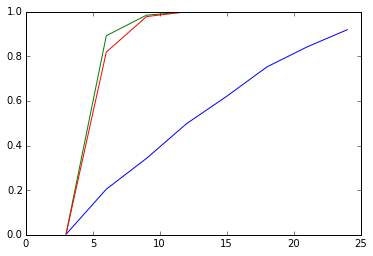

In [20]:
% matplotlib inline
plt.plot(v_m_counts, v_m_power.mean(0))
plt.plot(v_a_counts, v_a_power.mean(0))
plt.plot(m_a_counts, m_a_power.mean(0))

In [21]:
nat_power = {('Ven', 'USA'): [v_a_counts, v_a_power],
             ('Ven', 'Mal'): [v_m_counts, v_m_power],
             ('Mal', 'USA'): [m_a_counts, m_a_power]}

In [22]:
with open(os.path.join(data_dir, 'nat.p'), 'wb') as f_:
    pickle.dump(nat_power, f_)

In [24]:
with open(os.path.join(data_dir, 'nat.p'), 'rb') as f_:
    nat_power = pickle.load(f_)

In [25]:
for k, (cnt, pwr) in nat_power.iteritems():
    eff = ap.z_effect(cnt, pwr)
    n = np.sum(np.isnan(eff) == False)
    m = np.round(np.nanmean(eff), 2)
    b = np.round(np.nanstd(eff) / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1), 2)
    print k, m, '[', m - b, ', ', m + b, ']'

('Mal', 'USA') 1.46 [ 1.26 ,  1.66 ]
('Ven', 'USA') 1.48 [ 1.25 ,  1.71 ]
('Ven', 'Mal') 0.81 [ 0.78 ,  0.84 ]


In [18]:
us_sub_map = us_peps.groupby('AGE_CAT').groups
b_a_ids = [us_sub_map[g] for g in ['adult', 'baby']]
c_a_ids = [us_sub_map[g] for g in ['adult', 'child']]
t_a_ids = [us_sub_map[g] for g in ['adult', 'teen']]
t_c_ids = [us_sub_map[g] for g in ['teen', 'child']]
t_b_ids = [us_sub_map[g] for g in ['teen', 'baby']]
c_b_ids = [us_sub_map[g] for g in ['child', 'baby']]

In [29]:
# b_a_power, b_a_counts = subsample_power(age_test, b_a_ids, min_counts=3, max_counts=10, counts_interval=1)
# b_t_power, b_t_counts = subsample_power(age_test, t_b_ids, min_counts=3, max_counts=10, counts_interval=1)
# b_c_power, b_c_counts = subsample_power(age_test, c_b_ids, min_counts=3, max_counts=10, counts_interval=1)
c_a_power, c_a_counts = subsample_power(age_test, c_a_ids, min_counts=3, max_counts=30, counts_interval=1)
t_a_power, t_a_counts = subsample_power(age_test, t_a_ids, min_counts=3, max_counts=30, counts_interval=1)
t_c_power, t_c_counts = subsample_power(age_test, t_c_ids, min_counts=3, max_counts=30, counts_interval=1)

In [32]:
us_study = {('baby', 'adult'): [b_a_power, b_a_counts, age_test(b_a_ids)],
            ('baby', 'teen'):  [b_t_power, b_t_counts, age_test(t_b_ids)],
            ('baby', 'child'): [b_c_power, b_c_counts, age_test(c_b_ids)],
            ('child', 'teen'): [t_c_power, t_c_counts, age_test(t_c_ids)],
            ('child', 'adult'): [c_a_power, c_a_counts, age_test(c_a_ids)],
            ('teen', 'adult'): [t_a_power, t_a_counts, age_test(t_a_ids)]
           }

In [33]:
with open(os.path.join(data_dir, 'us_age.p'), 'wb') as f_:
    pickle.dump(us_study, f_)

In [35]:
for group, [pwr, cnt, p] in us_study.iteritems():
    eff = ap.z_effect(cnt, pwr)
    n = np.sum(np.isnan(eff) == False)
    print group, np.round(np.nanmean(eff), 2), np.round(np.nanstd(eff) / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1), 2)

('teen', 'adult') 0.34 0.01
('child', 'adult') 0.44 0.02
('child', 'teen') 0.14 0.01
('baby', 'child') 1.78 0.23
('baby', 'teen') 1.7 0.28
('baby', 'adult') 1.81 0.25


In [37]:
1.81 - 0.25, 1.81 + 0.25

(1.42, 1.98)